# Pluto Spatial Join
Example of joining data to street segment using PLUTO. Three parts:
1. Data Ingestion
2. Spatial Join of Pluto to Road Segments
3. Aggregating data by id 

In [0]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

from fiona.crs import from_epsg
%matplotlib inline

### I. Import shapefiles and convert to appropriate coordinate system

In [0]:
# Ingest data and convert to long island state plane so we can use ft as units
segs = gpd.read_file('../data/osmnx_nyc/osm_w_collisions/edges/edges.shp').to_crs({'init': 'epsg:2263'})
nodes = gpd.read_file('../data/osmnx_nyc/osm_w_collisions/nodes/nodes.shp').to_crs({'init': 'epsg:2263'})
pluto = gpd.read_file('../data/pluto/pluto.shp').to_crs({'init': 'epsg:2263'})

(990080.244544738, 994709.4167496201, 211719.62412157076, 215777.31813590435)

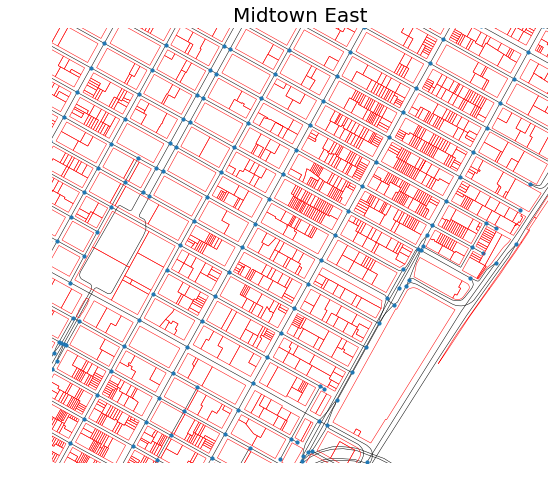

In [0]:
fig, ax = plt.subplots(figsize=(12,8))
ax.set_xlim(990080.244544738, 994709.4167496201)
ax.set_ylim(211719.62412157076, 215777.31813590435)
ax.set_title('Midtown East', fontsize=20)
segs.plot(color='black', ax= ax, lw=0.5, zorder=-1)
nodes.plot(markersize=10, ax= ax)
pluto.plot(facecolor='None', edgecolor='red', lw=0.5, ax=ax)
ax.axis('off')

### II. Spatially join road data to Pluto shapefile

In [0]:
segs_buff = segs.copy()
#cap style of two so end points aren't rounded
segs_buff['geometry'] = segs_buff.geometry.buffer(50, cap_style=2)
#use left join so pluto buildings can get joined to more than one street
pluto_joined = gpd.sjoin(pluto, segs_buff, how='left')
pluto_joined.head()

,Borough,Block,Lot,CD,CT2010,CB2010,SchoolDist,Council,ZipCode,FireComp,...,RBlockFace,FIRST_Traf,MAX_Number,MAX_Numb_1,MAX_Numb_2,MAX_POSTED,FIRST_Bike,FIRST_Stre,MAX_Street,MIN_Street
0,MN,1,10,101,5,1022,02,1,10004,E007,...,0212261734,W,2,None,2,40,None,HUGH L CAREY TUNNEL,56.0,18.0
0,MN,1,10,101,5,1022,02,1,10004,E007,...,0212262215,A,2,None,2,40,None,HUGH L CAREY TUNNEL,40.0,18.0
1,MN,1,101,101,1,1001,02,1,10004,E007,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,MN,1,201,101,1,1000,02,1,10004,E007,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,MN,2,1,101,9,1025,02,1,10004,L015,...,1222607159,W,2,None,2,40,None,FDR DRIVE VIADUCT,24.0,22.0


In [0]:
# visualize joined data
# fig, ax = plt.subplots(figsize=(12,8))
# n=len(pluto_joined.osmid.unique())
# color=iter(cm.Set1(np.linspace(0,1,n)))

# for x in pluto_joined.id.unique():
#     c=next(color)
#     pluto_joined[pluto_joined.id == x].plot(ax=ax, facecolor=c, alpha=0.3)
    
# ax.set_title('Buffered Streets + PLUTO', fontsize=20)
# segs.geometry.buffer(50, cap_style=2).plot(edgecolor='black', facecolor='lightgrey', ax= ax, lw=0.5, zorder=-1, alpha=0.4)
# ax.axis('off')
pluto_joined.shape

(1054412, 120)

### III. Aggregate Pluto Data per segment
Needs to answer the following questions:
* Land use
    * Single Family Home/Duplex Attached- *count*
    * Town Homes/Row Houses- *count*
    * Condo/Apartment Housing- *count*
    * Medium or Heavy Industrial (e.g., chemical plants, oil wells, etc)- *count*
    * Industrial, Other- *count*
    * Undeveloped Land- *binary*
    * Do the buildings in this segment contain vertical mixed use, that is, the building has different land uses on different floors of the builiding.- *binary, more than one use*
* Number Floors
    * 1 Story- *count*
    * 2 to 3 Stories- *count*
    * 4 to 8 Stories- *count*
    * 9 to 12 Stories- *count*
    * 13 to 39 Stories- *count*
    * 40+ Stories- *count*
    * How many stories are most buildings in the segment?- *mode*
* What is the predominant age of most buildings on this segment?- *mode*

In [0]:
# available columns
pluto_joined.columns[:100]

Index(['Borough', 'Block', 'Lot', 'CD', 'CT2010', 'CB2010', 'SchoolDist',
       'Council', 'ZipCode', 'FireComp', 'PolicePrct', 'HealthCent',
       'HealthArea', 'Sanitboro', 'SanitDistr', 'SanitSub', 'Address',
       'ZoneDist1', 'ZoneDist2', 'ZoneDist3', 'ZoneDist4', 'Overlay1',
       'Overlay2', 'SPDist1', 'SPDist2', 'SPDist3', 'LtdHeight', 'SplitZone',
       'BldgClass', 'LandUse', 'Easements', 'OwnerType', 'OwnerName',
       'LotArea', 'BldgArea', 'ComArea', 'ResArea', 'OfficeArea', 'RetailArea',
       'GarageArea', 'StrgeArea', 'FactryArea', 'OtherArea', 'AreaSource',
       'NumBldgs', 'NumFloors', 'UnitsRes', 'UnitsTotal', 'LotFront',
       'LotDepth', 'BldgFront', 'BldgDepth', 'Ext', 'ProxCode', 'IrrLotCode',
       'LotType', 'BsmtCode', 'AssessLand', 'AssessTot', 'ExemptLand',
       'ExemptTot', 'YearBuilt', 'YearAlter1', 'YearAlter2', 'HistDist',
       'Landmark', 'BuiltFAR', 'ResidFAR', 'CommFAR', 'FacilFAR', 'BoroCode',
       'BBL', 'CondoNo', 'Tract2010', 'XCo

#### Year Built

In [0]:
def findMode(df, field):
    return df[df[field] != 0].groupby('id')[field].agg(lambda x:x.value_counts().index[0])

In [0]:
# start with year built
commonyear = findMode(pluto_joined, 'YearBuilt')
commonyear.head()

id
1.0    1933
2.0    1993
3.0    1960
4.0    1933
5.0    1920
Name: YearBuilt, dtype: int64

#### Number of floors

In [0]:
# most common number of floors
commonfloors = findMode(pluto_joined, 'NumFloors')
commonfloors.head()

id
1.0    2.0
2.0    2.0
3.0    2.0
4.0    1.0
5.0    2.0
Name: NumFloors, dtype: float64

In [0]:
# bin floors
cats = ['1 Floor','2-3 Floors','4-8 Floors','9-13 Floors','14-39 Floors','40+ Floors']
pluto_joined['floorCat'] = pd.cut(pluto_joined.NumFloors, [0.9,1.9,3.9,8.9,13.9,39.9,120],
                                  labels=cats)

In [0]:
floor_breakdown = pluto_joined.groupby(['id', 'floorCat']).count()
floor_breakdown = floor_breakdown.reset_index().pivot_table(columns='floorCat', index='id', values='Block').fillna(0)
floor_breakdown.head()

floorCat,1 Floor,2-3 Floors,4-8 Floors,9-13 Floors,14-39 Floors,40+ Floors
id,,,,,,
1.0,1.0,2.0,0.0,0.0,0.0,0.0
2.0,0.0,2.0,0.0,0.0,0.0,0.0
3.0,2.0,2.0,1.0,0.0,0.0,0.0
4.0,2.0,2.0,1.0,0.0,0.0,0.0
5.0,2.0,14.0,3.0,0.0,0.0,0.0


#### Land Use

In [0]:
# is there mixed use?
## check whether buildings have more than one use type
def isMixed(x):
    types = 0
    for val in ['ResArea', 'OfficeArea', 'RetailArea', 'FactryArea']:
        if x[val] > 0:
            types += 1
    return(types>=2)

pluto_joined['isMixed'] = pluto_joined.apply(isMixed, axis=1)
mixedBlock = pluto_joined.groupby('id')['isMixed'].any()
mixedBlock.head(7)

id
1.0     True
2.0     True
3.0     True
4.0     True
5.0    False
6.0    False
7.0    False
Name: isMixed, dtype: bool

In [0]:
# https://www1.nyc.gov/assets/planning/download/pdf/data-maps/open-data/pluto_datadictionary.pdf?r=18v21beta
landUseCodes = {'01': 'One & Two Family Buildings',
'02': 'Multi-Family Walk-Up Buildings',
'03': 'Multi-Family Elevator Buildings',
'04': 'Mixed Residential & Commercial Buildings',
'05': 'Commercial & Office Buildings',
'06': 'Industrial & Manufacturing',
'07': 'Transportation & Utility',
'08': 'Public Facilities & Institutions',
'09': 'Open Space & Outdoor Recreation',
'10': 'Parking Facilities',
'11': 'Vacant Land'}

*What we want*
* Single Family Home/Duplex Attached- *count*
* Town Homes/Row Houses- *count*
* Condo/Apartment Housing- *count*
* Medium or Heavy Industrial (e.g., chemical plants, oil wells, etc)- *count*
* Industrial, Other- *count*
* Undeveloped Land- *binary*

In [0]:
# counts of landuse
landuse = pluto_joined.groupby(['id', 'LandUse']).count()
landuse = landuse.reset_index().pivot_table(columns='LandUse', index='id', values='Block').fillna(0)
landuse.rename(columns=landUseCodes, inplace=True)
landuse.head()

LandUse,One & Two Family Buildings,Multi-Family Walk-Up Buildings,Multi-Family Elevator Buildings,Mixed Residential & Commercial Buildings,Commercial & Office Buildings,Industrial & Manufacturing,Transportation & Utility,Public Facilities & Institutions,Open Space & Outdoor Recreation,Parking Facilities,Vacant Land
id,,,,,,,,,,,
1.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0
2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0
3.0,0.0,0.0,0.0,0.0,1.0,4.0,0.0,0.0,0.0,1.0,1.0
4.0,0.0,0.0,0.0,0.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0
5.0,14.0,3.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0


In [0]:
# aggregate into single dataframe
commonyear.name = 'commonYear'
commonfloors.name = 'commonFloors'
mixedBlock.name = 'mixedBlock'
segs_joined = segs.merge(commonyear.to_frame(), left_on='id', right_index=True, suffixes=['','delete_'])
segs_joined = segs_joined.merge(commonfloors.to_frame(), left_on='id', right_index=True, suffixes=['','delete_'])
segs_joined = segs_joined.merge(mixedBlock.to_frame(), left_on='id', right_index=True, suffixes=['','delete_'])
segs_joined = segs_joined.merge(floor_breakdown, left_on='id', right_index=True, suffixes=['','delete_'])
segs_joined = segs_joined.merge(landuse, left_on='id', right_index=True, suffixes=['','delete_'])

segs_joined.head()

,access,bridge,from,highway,junction,key,lanes,length,maxspeed,name,...,Multi-Family Walk-Up Buildings,Multi-Family Elevator Buildings,Mixed Residential & Commercial Buildings,Commercial & Office Buildings,Industrial & Manufacturing,Transportation & Utility,Public Facilities & Institutions,Open Space & Outdoor Recreation,Parking Facilities,Vacant Land
0,None,None,42817478,residential,None,0,None,81.315,20 mph,47th Avenue,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0
1,None,None,42860543,residential,None,0,None,114.648,20 mph,47th Avenue,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0
2,None,None,42872051,residential,None,0,None,161.961,None,27th Street,...,0.0,0.0,0.0,1.0,4.0,0.0,0.0,0.0,1.0,1.0
3,None,None,42872047,residential,None,0,None,87.217,None,27th Street,...,0.0,0.0,0.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0
4,None,None,42510401,residential,None,0,None,170.68,None,Schenectady Avenue,...,3.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0


In [0]:
segs_joined.to_csv('../data/road_join/segs_w_pluto.csv')

geopandas.geodataframe.GeoDataFrame